In [62]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, LeaveOneOut
from utilities import train_test_val_split, load_matlab_data, rmse
from sklearn.metrics import make_scorer

In [63]:
t = np.arange(1, 101)
x1 = np.sin(t) + 0.01 * np.random.rand(t.shape[0])
x2 = 10 * np.sin(t) + 0.01 * np.random.rand(t.shape[0])
x = np.hstack([x1.reshape((-1, 1)), x2.reshape((-1, 1))])
y = 0.1 * x[:,0] + 0.9 * x[:,1] + np.random.rand(t.shape[0])

In [64]:
xtr, ytr, xts, yts, xv, yv = train_test_val_split(x, y)
ytr = ytr.reshape((-1, 1))
yts = yts.reshape((-1, 1))
yv = yv.reshape((-1, 1))

In [65]:
xscaler = StandardScaler().fit(xtr)
yscaler = StandardScaler().fit(ytr)

In [66]:
xs = xscaler.transform(xtr)
ys = yscaler.transform(ytr)

In [67]:
lin = LinearRegression().fit(xs, ys)

In [68]:
# Find best alpha value with Leave One Out Cross validation
alpha_params = np.logspace(-2, 2)
params = {'alpha': alpha_params}
ridge_loo = GridSearchCV(Ridge(fit_intercept=False), param_grid=params, 
                     scoring=make_scorer(rmse, greater_is_better=False), 
                     cv=LeaveOneOut())
ridge_loo.fit(xs, ys)
a = ridge_loo.best_estimator_.alpha
print(f"Best alpha was {a}")

Best alpha was 0.030888435964774818


In [69]:
rmse(yts, yscaler.inverse_transform(lin.predict(xscaler.transform(xts))))

0.3306703625334227

In [70]:
rmse(yts, yscaler.inverse_transform(ridge.predict(xscaler.transform(xts))))

0.33052968553871737

In [71]:
np.linalg.cond(xtr.T @ xtr)

2240834.378161672

In [72]:
np.linalg.cond(xs.T @ xs)

242093.64636974662

In [73]:
def cond_ridge(x, alpha):
    s = np.linalg.svd(x.T @ x)[1]
    return (np.max(s) + alpha**2) / (np.min(s) + alpha**2)

In [74]:
cond_ridge(xs, a)

93760.33592045252

In [75]:
# Find best alpha value with 10-fold cross validation
alpha_params = np.logspace(-2, 2)
params = {'alpha': alpha_params}
ridge_cv10 = GridSearchCV(Ridge(fit_intercept=False), param_grid=params, 
                     scoring=make_scorer(rmse, greater_is_better=False), 
                     cv=10)
ridge_cv10.fit(xs, ys)
a = ridge_cv10.best_estimator_.alpha
print(f"Best alpha was {a}")

Best alpha was 0.0655128556859551


In [76]:
# Find best alpha value with 3-fold cross validation
alpha_params = np.logspace(-2, 2)
params = {'alpha': alpha_params}
ridge_cv3 = GridSearchCV(Ridge(fit_intercept=False), param_grid=params, 
                     scoring=make_scorer(rmse, greater_is_better=False), 
                     cv=3)
ridge_cv3.fit(xs, ys)
a = ridge_cv3.best_estimator_.alpha
print(f"Best alpha was {a}")

Best alpha was 0.030888435964774818


In [77]:
def best_alpha(folds, x, y):
    alpha_params = np.logspace(-2, 2)
    params = {'alpha': alpha_params}
    r = GridSearchCV(Ridge(fit_intercept=False), 
                     param_grid=params, 
                     scoring=make_scorer(rmse, greater_is_better=False), 
                     cv=folds)
    r.fit(x, y)
    a = r.best_estimator_.alpha
    return a

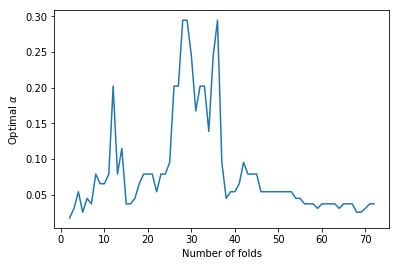

In [78]:
folds = np.arange(2, xs.shape[0])
alphas = [best_alpha(f, xs, ys) for f in folds]
plt.plot(folds, alphas)
plt.xlabel("Number of folds")
plt.ylabel(r"Optimal $\alpha$")
plt.show()

In [89]:
alpha_params = np.logspace(-3, 2)
# Generate a model for each alpha value
models = [Ridge(alpha=a, fit_intercept=False).fit(xs, ys) for a in alpha_params]
norm_b = [la.norm(m.coef_) for m in models]
yts_scaled_pred = [m.predict(xscaler.transform(xts)) for m in models]
rmse_vals = [rmse(yts, yscaler.inverse_transform(y)) for y in yts_scaled_pred]

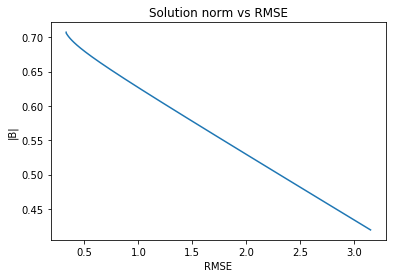

In [90]:
plt.plot(rmse_vals, norm_b)
plt.ylabel("|B|")
plt.xlabel("RMSE")
plt.show()

In [103]:
opt_b = np.array(rmse_vals) ** 2 + np.array(norm_b) ** 2
print(np.where(opt_b == np.min(opt_b)))
print(min(opt_b))
print(alpha_params[11])

(array([11]),)
0.6081077078487092
0.013257113655901095


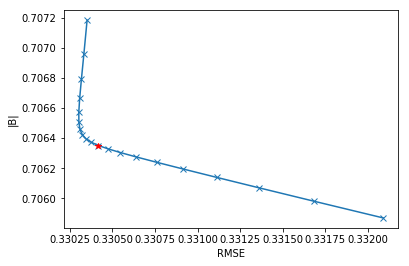

In [104]:
opt_b_loc = np.where(opt_b == np.min(opt_b))[0][0]
start_ind = max([0, opt_b_loc-10])
end_ind = min([opt_b.shape[0], opt_b_loc+10])
plt.plot(rmse_vals[start_ind:end_ind], norm_b[start_ind:end_ind], 'x-')
plt.plot(rmse_vals[opt_b_loc], norm_b[opt_b_loc], 'r*')
plt.ylabel("|B|")
plt.xlabel("RMSE")
plt.show()

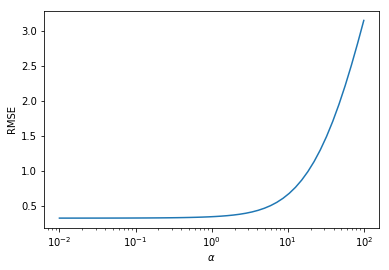

In [81]:
plt.plot(alpha_params, rmse_vals)
plt.xscale('log')
plt.xlabel(r"$\alpha$")
plt.ylabel("RMSE")
plt.show()

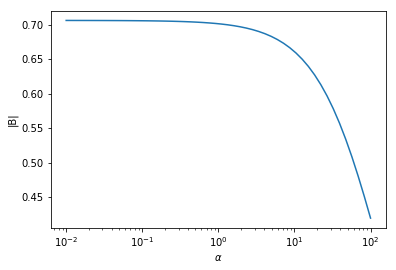

In [82]:
plt.plot(alpha_params, norm_b)
plt.xscale('log')
plt.xlabel(r"$\alpha$")
plt.ylabel("|B|")
plt.show()

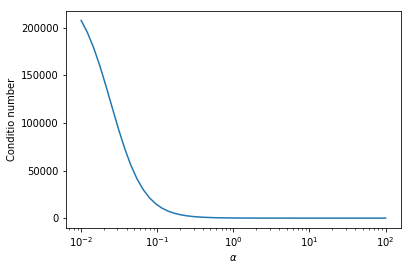

In [83]:
plt.plot(alpha_params, [cond_ridge(xs, a) for a in alpha_params])
plt.xscale('log')
plt.xlabel(r"$\alpha$")
plt.ylabel("Condition number")
plt.show()